In [52]:
def hama_response(N):
    filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--00000.dat'
    time,h = np.loadtxt(filename,unpack=True)
    ids = np.random.randint(1,300,size=(N-1,1))
    for id in ids:
        filename = 'ave1/C1--HighPulse-in-100-out1700-an2100--%05i.dat' % id
        time,hi = np.loadtxt(filename,unpack=True)
        h = np.row_stack((h,hi))
    return time,h

In [53]:
def gaussian_pde(time,N,rate,width):
    #define the probability distribution here
    mu = time[3*len(time)/4]
    pde = (1/np.sqrt(width**2*np.pi*2))*np.exp(-(rate*(time[len(time)/2:]-mu)*1.0e9)**2/width)

    fig = plt.figure()
    plt.plot(time[len(time)/2:],pde)
    plt.grid(True)
    plt.title('PDE')
    
    ids=[]
    count = 0
    while count!= N:
        for i in range(len(pde)):
            if np.random.choice([1,0], p=[pde[i],1-pde[i]]) == 1:
                ids = np.append(ids,len(time)/2+i)
                count +=1
                break
    return ids.astype(int)

<IPython.core.display.Javascript object>


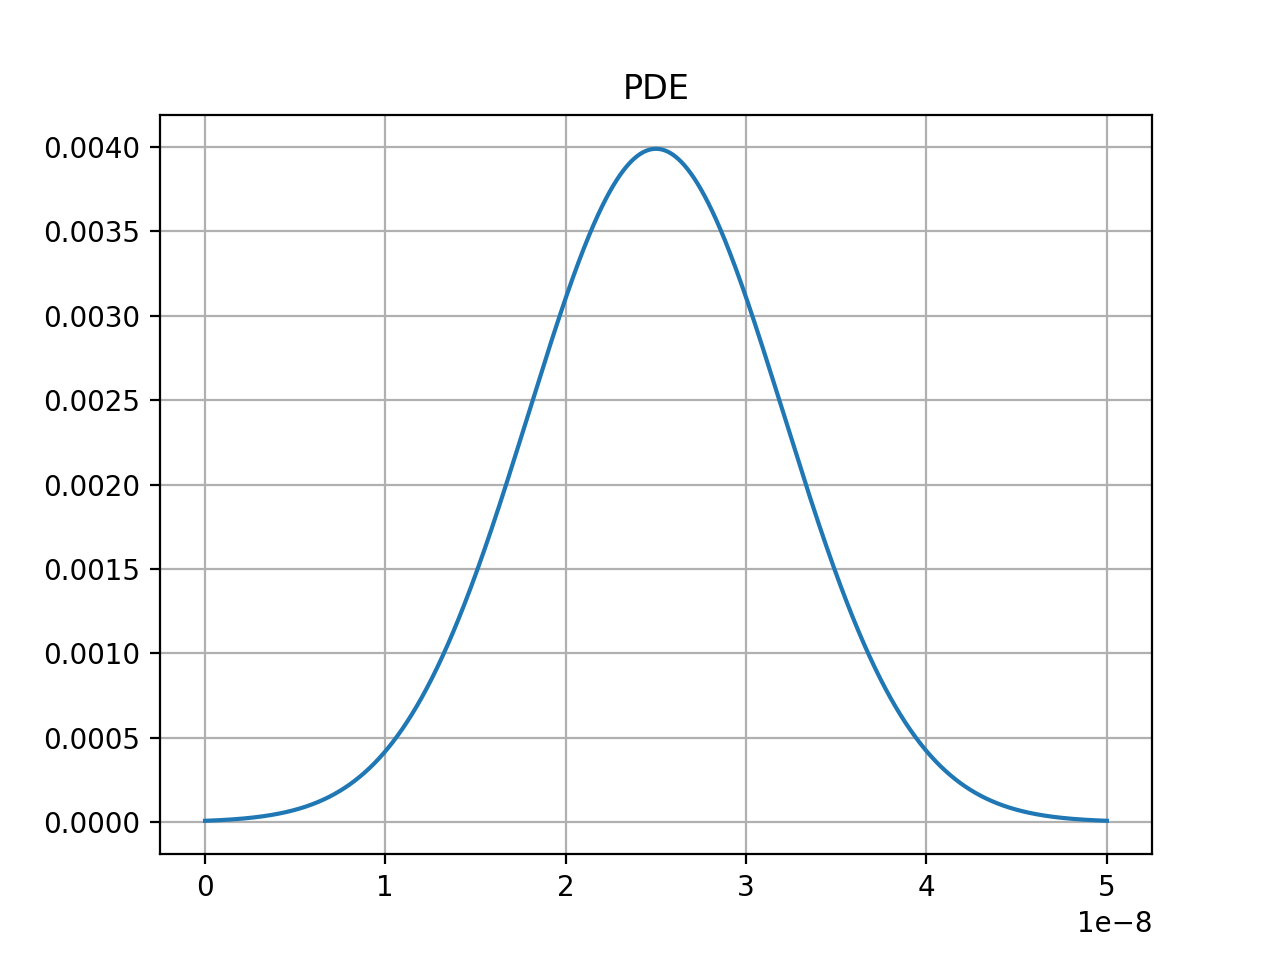

<IPython.core.display.Javascript object>


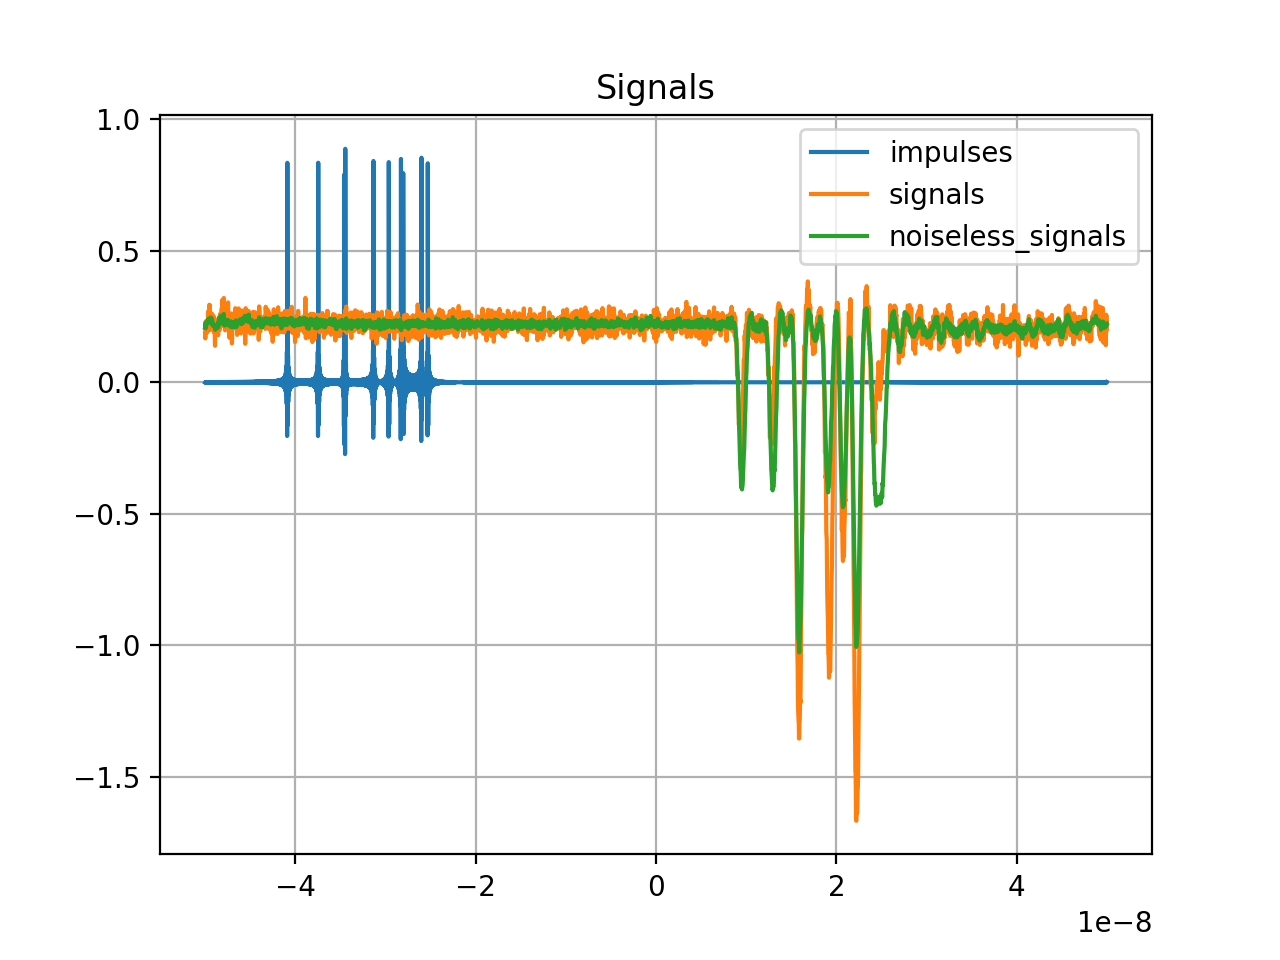

In [99]:
%matplotlib notebook

import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
import matplotlib.pyplot as plt

N = 10

time, h = hama_response(N)
havg = np.mean(h,axis=0)
H = fft(h,axis=1)
Havg = fft(havg)

freq = fftfreq(time.size,d = time[1]-time[0])

"""#random distribution of hits
index = np.random.randint(len(time)/2,len(time),size=(N,1))
"""

#gaussian probability distribution of hits
rate = 1.0   #sampling rate
width = 100.0  #gaussian width
index = gaussian_pde(time,N,rate,width)
index = np.resize(index,(N,1))

#print index

S = np.exp(-2*np.pi*1j*freq*time[index])
G = S*H

S = np.sum(S,axis=0)
Gavg = S*Havg

G = np.sum(G,axis=0)

s = np.real(ifft(S))
g = np.real(ifft(G))
gavg = np.real(ifft(Gavg))

fig = plt.figure()
ax = fig.subplots()
ax.plot(time,s,label='impulses')
ax.plot(time,g,label='signals')
ax.plot(time,gavg,label='noiseless_signals')
ax.set_title(label='Signals')
ax.grid(True)
ax.legend()
#fig = plt.figure()
#plt.plot(freq,np.abs(Havg))

[ 0.0184912   0.0221143   0.02486817 ...,  0.02277589  0.02395265
  0.02147705]


<IPython.core.display.Javascript object>


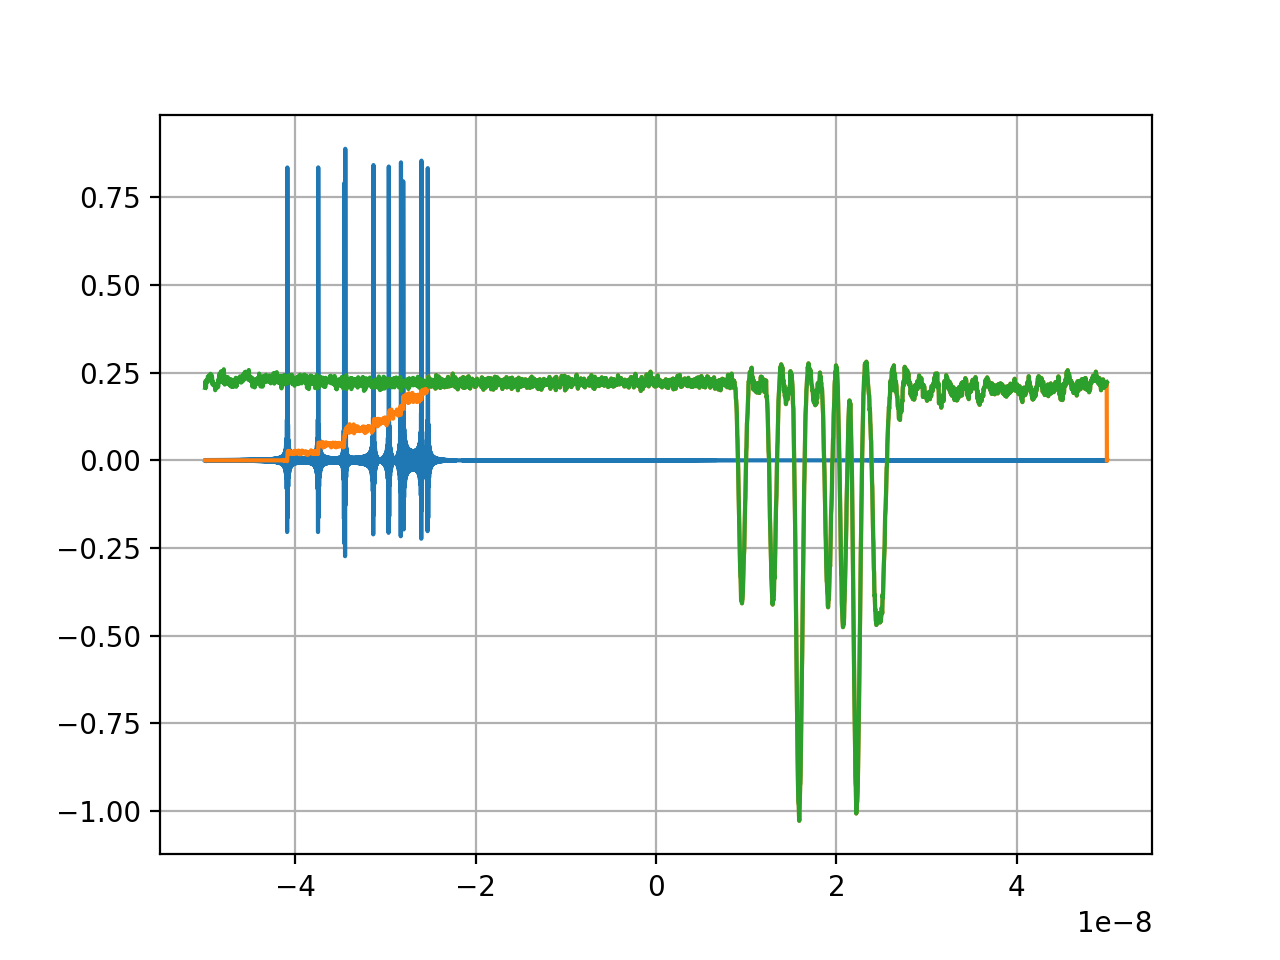

In [100]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

#Now we need to figure out how to deconvolve gavg(t) into s(t) without going to the fourier domain.
#This would help us to generate a filter set which can be inmplemented on FPGA without the cost of implementing FFT
#We can use TD Deconvolution method when kernel has no spectral inverse

#This is the first step towards this goal(maybe). Here I implement a convolution using a matrix multiplication.
print havg
hmat = np.zeros((havg.size,havg.size))
for i in range(havg.size-1):
    for k in range(i+1):
        hmat[i][k]=havg[i-k] 
y = np.matmul(hmat,s)
fig = plt.figure()
plt.plot(time,s)
plt.plot(time,y)
plt.plot(time,gavg)
plt.grid(True)

#Note on time complexity: ~O(n^2) time for n points in signal but this is a one time assignment operation.
#The signal for t<0 doesnt agree completely but s(t<0) is meaningless in the context of real signals.
#I tried to find the inverse using hmat^-1 but the spectrum contains zeros!